Regularized Abel Inversion
==========================

This example demonstrates a TV-regularized Abel inversion using
an Abel projector based on PyAbel <cite data-cite="pyabel-2022"/>

In [1]:
import numpy as np

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.examples import create_circular_phantom
from scico.linop.abel import AbelProjector
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
x_gt = create_circular_phantom((256, 254), [100, 50, 25], [1, 0, 0.5])

Set up the forward operator and create a test measurement

In [3]:
A = AbelProjector(x_gt.shape)
y = A @ x_gt
np.random.seed(12345)
y = y + np.random.normal(size=y.shape).astype(np.float32)
ATy = A.T @ y

Set up ADMM solver object.

In [4]:
λ = 1.9e01  # L1 norm regularization parameter
ρ = 4.9e01  # ADMM penalty parameter
maxiter = 100  # number of ADMM iterations
cg_tol = 1e-4  # CG relative tolerance
cg_maxiter = 25  # maximum CG iterations per ADMM iteration

g = λ * functional.L1Norm()
C = linop.FiniteDifference(input_shape=x_gt.shape)

f = loss.SquaredL2Loss(y=y, A=A)

x_inv = A.inverse(y)
x0 = snp.clip(x_inv, 0, 1.0)

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=x0,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
    itstat_options={"display": True, "period": 5},
)

Run the solver.

In [5]:
print(f"Solving on {device_info()}\n")
solver.solve()
hist = solver.itstat_object.history(transpose=True)
x_tv = snp.clip(solver.x, 0, 1.0)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.28e+00  3.027e+04  4.339e+01  8.950e+01     18  9.234e-05
   5  3.11e+00  4.814e+04  3.646e+00  3.055e+00      6  9.153e-05


  10  3.19e+00  5.134e+04  1.996e+00  7.210e-01      5  9.562e-05
  15  3.25e+00  5.216e+04  1.676e+00  1.969e-01      0  9.752e-05
  20  3.32e+00  5.297e+04  1.235e+00  1.480e-01      0  8.923e-05
  25  3.37e+00  5.396e+04  1.075e+00  9.327e-02      0  9.159e-05


  30  3.40e+00  5.380e+04  9.617e-01  9.957e-02      0  8.273e-05
  35  3.44e+00  5.424e+04  7.887e-01  7.055e-02      0  8.778e-05
  40  3.47e+00  5.493e+04  1.232e+00  7.985e-02      0  8.465e-05
  45  3.50e+00  5.463e+04  9.317e-01  9.782e-02      0  9.900e-05
  50  3.53e+00  5.477e+04  8.687e-01  7.403e-02      0  8.961e-05
  55  3.56e+00  5.490e+04  7.374e-01  6.075e-02      0  6.255e-05


  60  3.61e+00  5.508e+04  1.391e+00  3.971e-01      4  7.568e-05
  65  3.64e+00  5.506e+04  1.208e+00  3.741e-01      4  8.399e-05
  70  3.68e+00  5.546e+04  1.818e+00  7.238e-01      5  6.455e-05
  75  3.72e+00  5.548e+04  1.989e+00  6.156e-01      4  5.883e-05
  80  3.75e+00  5.543e+04  1.146e+00  3.294e-01      5  6.649e-05
  85  3.79e+00  5.527e+04  7.852e-01  6.040e-02      0  8.061e-05


  90  3.82e+00  5.542e+04  4.663e-01  3.571e-02      0  8.972e-05
  95  3.85e+00  5.545e+04  3.872e-01  2.499e-02      0  8.948e-05
  99  3.87e+00  5.544e+04  3.116e-01  2.658e-02      0  9.863e-05


Show results.

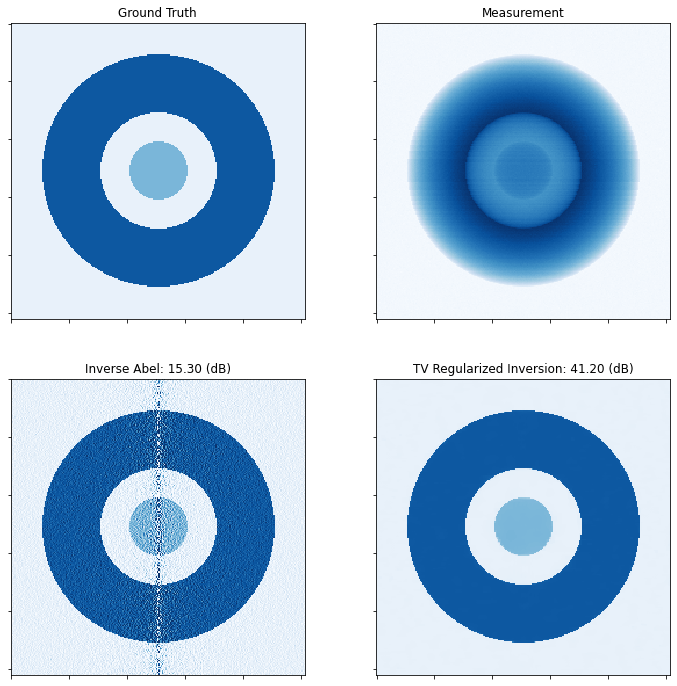

In [6]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1, vmax=1.2)
fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot.imview(x_gt, title="Ground Truth", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 0], norm=norm)
plot.imview(y, title="Measurement", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 1])
plot.imview(
    x_inv,
    title="Inverse Abel: %.2f (dB)" % metric.psnr(x_gt, x_inv),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1, 0],
    norm=norm,
)
plot.imview(
    x_tv,
    title="TV Regularized Inversion: %.2f (dB)" % metric.psnr(x_gt, x_tv),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1, 1],
    norm=norm,
)
fig.show()